# Advanced Lane Finding Project

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Step1-a.  Find Chessboard Corners

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def draw_Corners(img, nx, ny):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Find Chessboard Corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

    # Draw Chessboard Corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

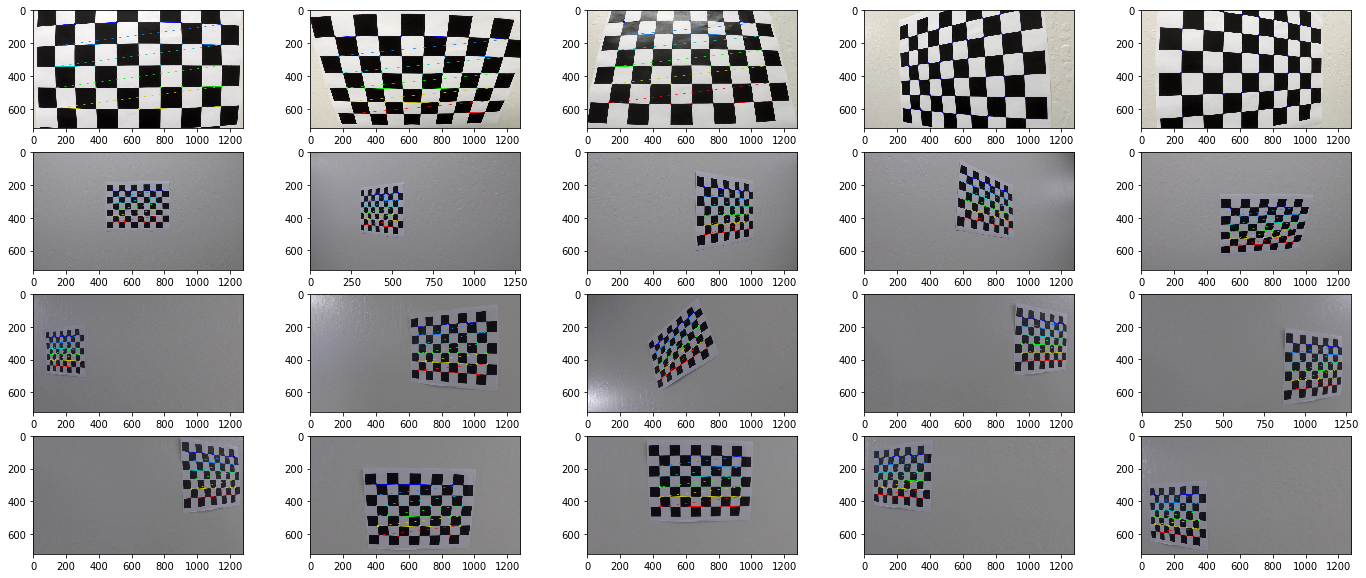

In [3]:
# show images with corners drew
images = []
for i in range(1,21):
    images.append('./camera_cal/calibration' + str(i) + '.jpg')

images_corner = []

#the example images has 9x6 corners
for i in range(20):
    images_corner.append(mpimg.imread(images[i]))
    if i == 0: # 'calibration1.jpg' has 9x5 corners 
        draw_Corners(images_corner[i], 9, 5)
    draw_Corners(images_corner[i], 9, 6)
    
# show images and corners
plt.figure(figsize = (24,10))
for i in range(1,21):
    plt.subplot(4,5,i)
    plt.imshow(images_corner[i-1])
plt.show()

## Step1-b. Compute the camera calibration

In [4]:
def undistortImg(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) 
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted

## Step2-a. Apply a distortion correction to Chessboard img

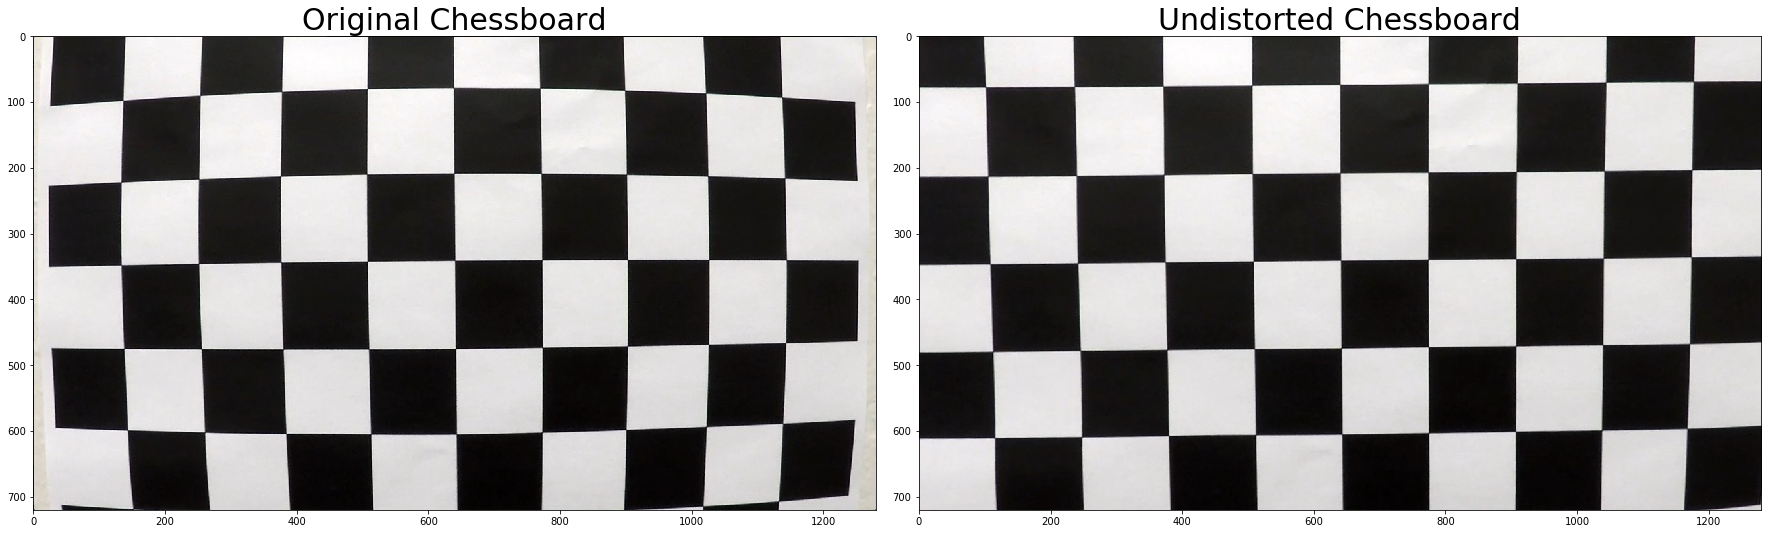

In [5]:
# load a example image
origin_Chessboard = mpimg.imread('./camera_cal/calibration1.jpg')
nx, ny = 9, 5
img = np.copy(origin_Chessboard)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
objpoints, imgpoints = [], []

ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)

# Apply a distortion correction
undistorted_Chessboard = undistortImg(origin_Chessboard, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(origin_Chessboard)
ax1.set_title('Original Chessboard', fontsize=30)
ax2.imshow(undistorted_Chessboard)
ax2.set_title('Undistorted Chessboard', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)  

## Step2-b. Apply a distortion correction to raw imgs

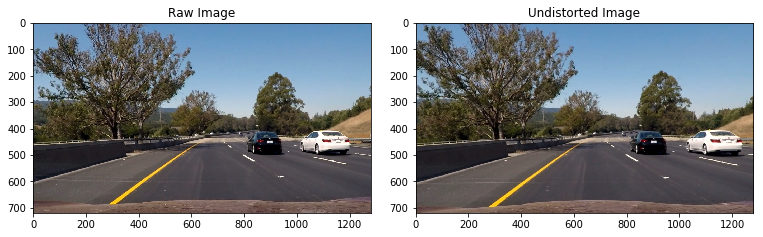

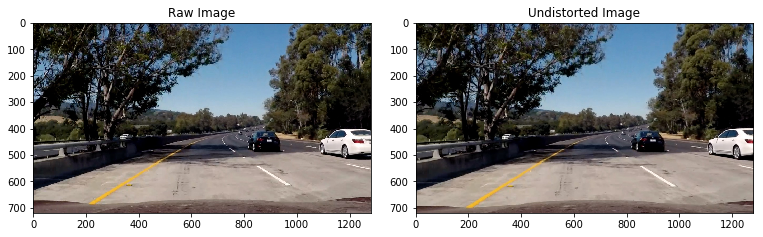

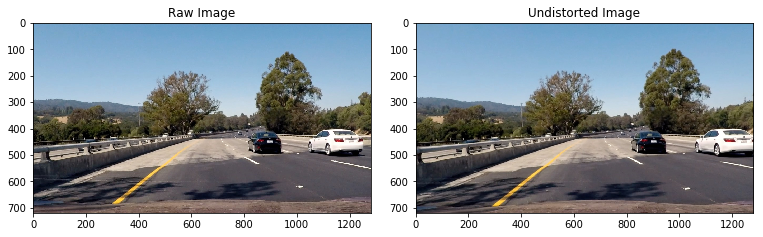

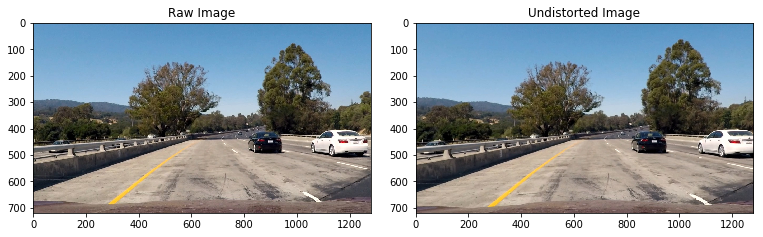

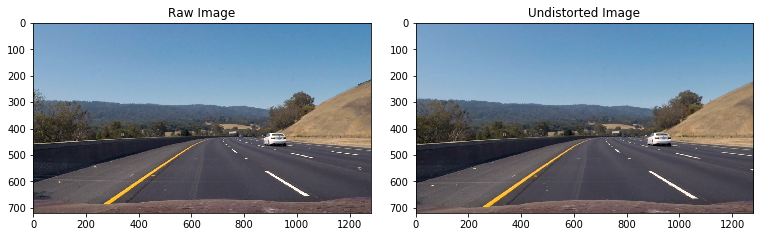

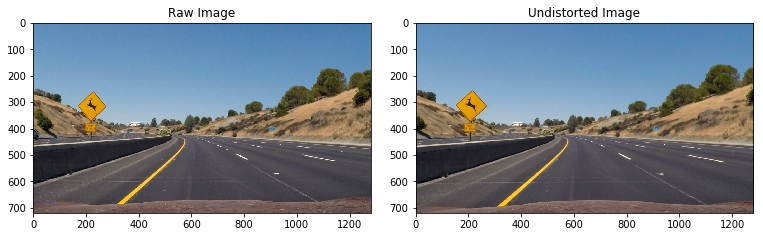

In [6]:
raw_imgs = glob.glob('./test_images/test*.jpg')
  
for i in range(6):
    img = mpimg.imread(raw_imgs[i])
    img_undistort = undistortImg(img, objpoints, imgpoints)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Raw Image', fontsize=12)
    ax2.imshow(img_undistort)
    ax2.set_title('Undistorted Image', fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

## Step3. Create a thresholded binary image

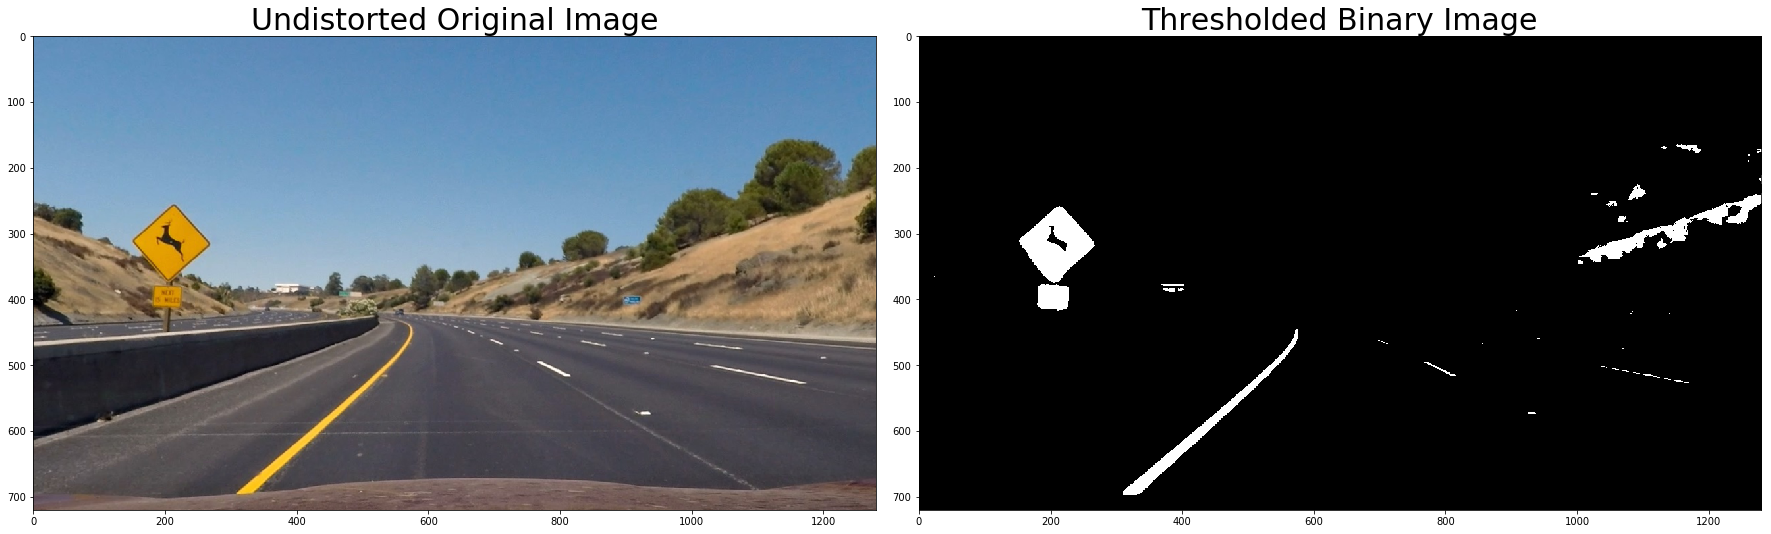

In [21]:
image = mpimg.imread('./test_images/test2.jpg')

img_undistort = undistortImg(image, objpoints, imgpoints)

def binary_thresh(img, b_thresh=(190,255), l_thresh=(220, 255)):
    img = np.copy(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Convert to Lab color space and separate the B channel
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    if np.max(b_channel) > 175:
        b_channel = np.uint8(b_channel*(255/np.max(b_channel)))
        
    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel = np.uint8(l_channel*(255/np.max(l_channel)))
       
    # Threshold Lab-B channel
    b_binary = np.zeros_like(b_channel)
    b_binary[((b_channel > b_thresh[0]) & (b_channel <= b_thresh[1]))] = 1
    
    # Threshold HLS-L channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(b_binary), b_binary, l_binary)) * 255
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1
    return combined_binary
    
binary_image = binary_thresh(img_undistort)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img_undistort)
ax1.set_title('Undistorted Original Image', fontsize=30)

ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Thresholded Binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step4. Apply a perspective transform ("birds-eye view")

In [22]:
def transformImg(image, src, dst):
    img_size = (image.shape[1], image.shape[0])
        
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return img_warped, M, Minv

In [23]:
src = np.float32([[550, 460],[730, 460],[1250, 719],[30, 719]])
dst = np.float32([[100, 1], [1180, 1], [1180, 719],[100, 719]])

origin_warped = transformImg(img_undistort, src, dst)[0]
binary_warped = transformImg(binary_image, src, dst)[0]

Minv = transformImg(img_undistort, src, dst)[2]

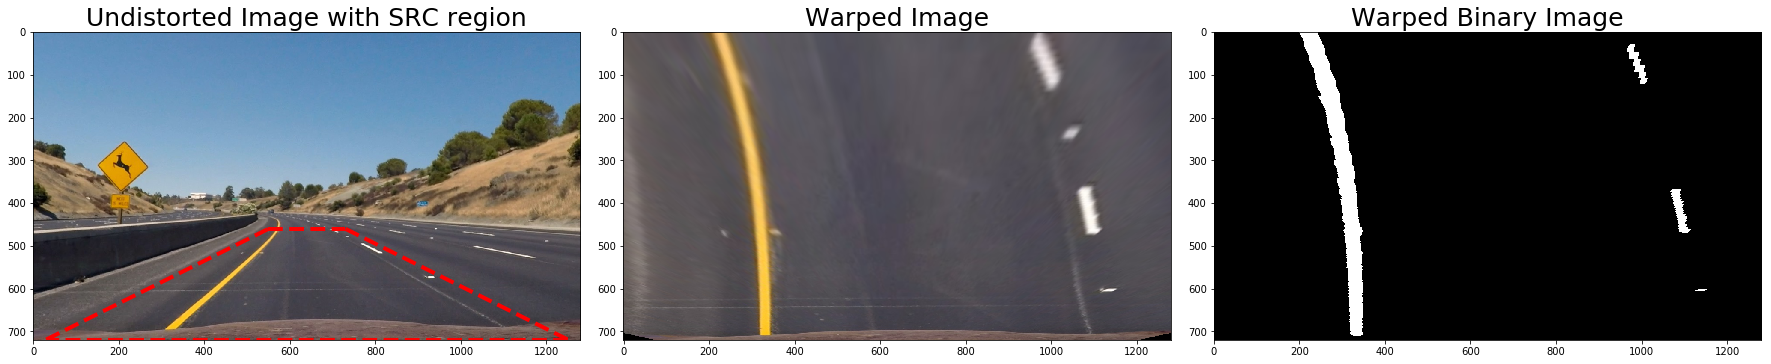

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_undistort)
ax1.set_title('Undistorted Image with SRC region', fontsize=25)
for i in range(4):
    x = [src[i][0],src[(i+1)%4][0]]
    y = [src[i][1],src[(i+1)%4][1]]
    ax1.plot(x, y, 'r--', lw=4)
ax2.imshow(origin_warped)
ax2.set_title('Warped Image', fontsize=25)
ax3.imshow(binary_warped, cmap='gray')
ax3.set_title('Warped Binary Image', fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

## Step5. Detect lane pixels and fit to find the lane boundary.

In [25]:
def binary_fit(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If > minpix pixels, recenter next window on mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = np.array([0,0,0])
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = np.array([0,0,0])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

In [26]:
def lane_boundary(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = np.array([0,0,0])
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = np.array([0,0,0])
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    return window_img, left_line_pts, right_line_pts, out_img

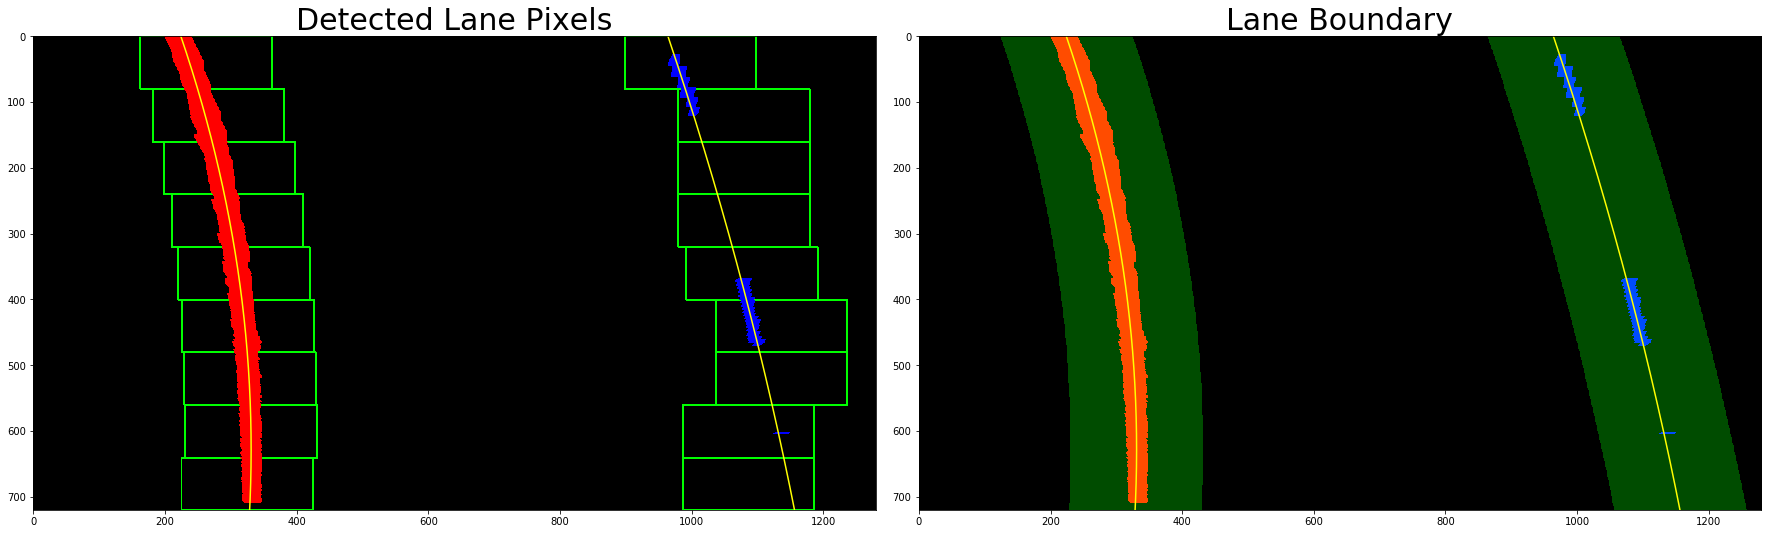

In [27]:
out_img_fit, left_fit, right_fit, left_fitx, right_fitx, ploty = binary_fit(binary_warped)
window_img, left_line_pts, right_line_pts, out_img_boundary = lane_boundary(binary_warped, left_fit, right_fit)

cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img_boundary, 1, window_img, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(out_img_fit)
ax1.set_title('Detected Lane Pixels', fontsize=30)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')

ax2.imshow(result)
ax2.set_title('Lane Boundary', fontsize=30)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step6. Determine the curvature of the lane and vehicle position with respect to center

In [28]:
def measure_Curvature(left_fitx, right_fitx):
    y_eval = np.max(ploty)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    mid_fit_cr = np.polyfit(ploty*ym_per_pix, (left_fitx + right_fitx)/2*xm_per_pix, 2)
    mid_curverad = ((1 + (2*mid_fit_cr[0]*y_eval*ym_per_pix + mid_fit_cr[1])**2)**1.5) / np.absolute(2*mid_fit_cr[0])

    vehicle_position_offset = ((left_fitx[-1] + right_fitx[-1])/2 - 640) * xm_per_pix
    if vehicle_position_offset > 0:
        offset_dirt = 'left'
    else:
        offset_dirt = 'right'
    
    text_RoC = 'Radius of Curvature = ' + str(int(mid_curverad)) + '(m)'
    text_offset = 'Vehicle is %.2f'%abs(vehicle_position_offset) + 'm ' + offset_dirt + ' of center'
    
    return text_RoC, text_offset

In [29]:
text_RoC, text_offset = measure_Curvature(left_fitx, right_fitx)
print(text_RoC)
print(text_offset)

Radius of Curvature = 894(m)
Vehicle is 0.54m left of center


## Step7. Warp the detected lane boundaries back onto the original image

In [30]:
def draw_Lane(img_undistort, binary_warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_undistort.shape[1], img_undistort.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undistort, 1, newwarp, 0.3, 0)
    
    return result

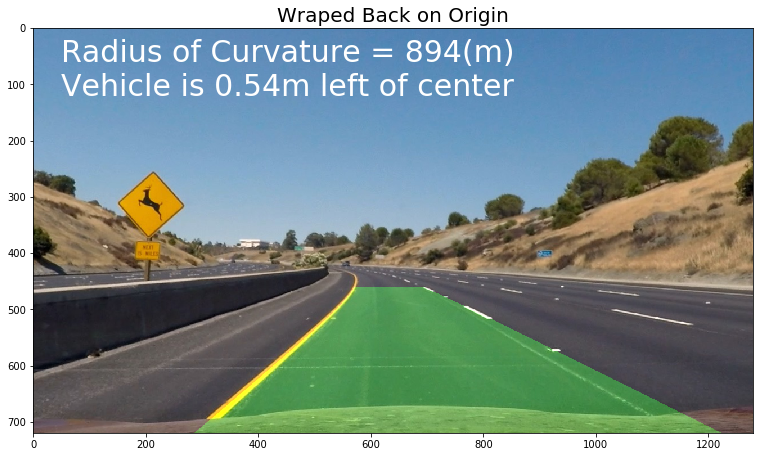

In [31]:
laneline_img = draw_Lane(img_undistort, binary_warped, left_fitx, right_fitx, ploty, Minv)

f, (ax1) = plt.subplots(1, 1, figsize=(10, 9))
f.tight_layout()
ax1.imshow(laneline_img)
ax1.set_title('Wraped Back on Origin', fontsize=20)
ax1.text(50, 60, text_RoC, color='white', fontsize=30)
ax1.text(50, 120, text_offset, color='white', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step8. Output visual display of the lane boundaries and numerical estimation

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def process_image(image):

    img_undistort = undistortImg(image, objpoints, imgpoints)
    binary_image = binary_thresh(img_undistort)

    src = np.float32([[550, 460],[730, 460],[1250, 719],[30, 719]])
    dst = np.float32([[30, 1], [1250, 1], [1250, 719],[30, 719]])

    origin_warped = transformImg(img_undistort, src, dst)[0]
    binary_warped = transformImg(binary_image, src, dst)[0]

    Minv = transformImg(img_undistort, src, dst)[2]

    out_img_fit, left_fit, right_fit, left_fitx, right_fitx, ploty = binary_fit(binary_warped)
    window_img, left_line_pts, right_line_pts, out_img_boundary = lane_boundary(binary_warped, left_fit, right_fit)

    text_RoC, text_offset = measure_Curvature(left_fitx, right_fitx)

    laneline_img = draw_Lane(img_undistort, binary_warped, left_fitx, right_fitx, ploty, Minv)

    result = cv2.putText(laneline_img, text_RoC, (50, 60), fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    result = cv2.putText(result, text_offset, (50, 120), fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)

    return result

In [20]:
white_output = './Advanced_Lane_Lines.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./Advanced_Lane_Lines.mp4
[MoviePy] Writing video ./Advanced_Lane_Lines.mp4


100%|█████████▉| 1260/1261 [02:38<00:00,  8.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Advanced_Lane_Lines.mp4 

CPU times: user 4min 47s, sys: 23.5 s, total: 5min 11s
Wall time: 2min 39s
